### ECE-GY 6123
### Nikita Makarov, Fall 2024

### Homework 3

Problem 1a:

In [166]:
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

# Create Gaussian Pyramid function
def gaussian_pyramid(im_data: np.ndarray, J: int) -> list[np.ndarray]:
    '''
    Compute and return the J-level Gaussian pyramid decomposition of a grayscale image.

    Parameters:
    im_data: 2D numpy array of the image data in grayscale
    J: int of the Gaussian pyramid level

    Returns:
    G: list of size J filled with 2D numpy arrays of the Gaussian pyramid, with the first element being level 0
    '''

    # Create Gaussian pyramid structure
    G = [im_data] # Create list with last element as level J

    # Iterate over all remaining levels
    for _ in range(0,J):
        width = int(im_data.shape[1]/2) # Calculate new width
        height = int(im_data.shape[0]/2) # Calculate new height
        im_data = cv2.resize(im_data,(width,height),interpolation=cv2.INTER_LINEAR) # Get next layer of image data
        G.insert(0, im_data) # Add new layer to front of list

    return G

# Create Laplacian Pyramid function
def laplacian_pyramid(im_data: np.ndarray, J: int) -> list[np.ndarray]:
    '''
    Compute and return the J-level Laplacian pyramid decomposition of a grayscale image.

    Parameters:
    im_data: 2D numpy array of the image data in grayscale
    J: int of the Laplacian pyramid level

    Returns:
    L: list of size J filled with 2D numpy arrays of the Laplacian pyramid, with the first element being level 0
    '''

    # Calculate Gaussian pyramid structure
    G = gaussian_pyramid(im_data, J)

    # Create Laplacian pyramid structure
    L = [G[0]] # Create list with first element as level 0

    # Iterate over all remaining levels
    for i in range(0,J):
        im_data = G[i+1] # Get first element in Gaussian pyramid
        (height,width) = im_data.shape # Get new width and height
        U = cv2.resize(G[i],(width,height),interpolation=cv2.INTER_CUBIC) # Perform upscaling for next layer
        L.append(im_data - U) # Add new layer to end of list

    return L


Problem 1b:

(np.float64(-0.5), np.float64(1151.5), np.float64(511.5), np.float64(-0.5))

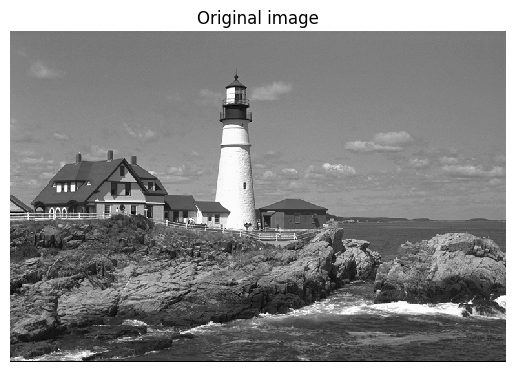

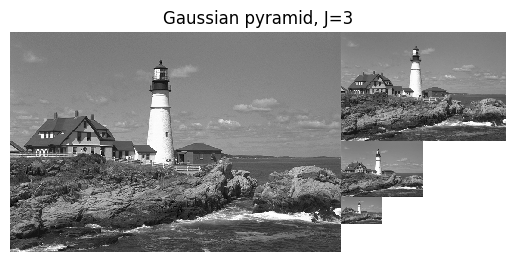

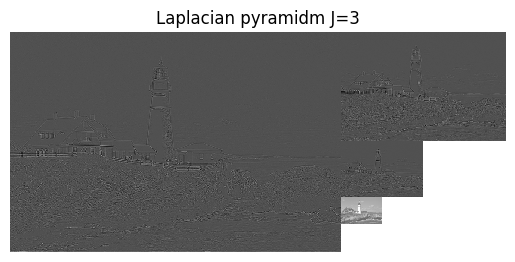

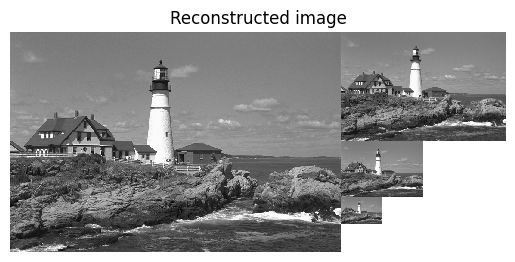

In [167]:
# Create Laplacian reconstruction function
def reconstruct_laplacian(L: list[np.ndarray]) -> list[np.ndarray]:
    '''
    Reconstruct and return a grayscale image from a Laplacian pyramid structure.

    Parameters:
    L: list of size J filled with 2D numpy arrays of the Laplacian pyramid, with the first element being element 0

    Returns:
    R: list of size J filled with 2D numpy array of the reconstructed image in grayscale
    '''

    # Create reconstructed image structure
    R = [L[0]]

    # Iterate over levels of the laplacian pyramid
    for i in range(0,len(L)-1):
        (height,width) = L[i+1].shape # Get new width and height
        U = cv2.resize(R[i],(width,height),interpolation=cv2.INTER_CUBIC) # Perform upscaling for next layer
        R.append(L[i+1] + U) # Calculate new reconstructed layer

    return R

# Create function for composite arrays for image display
def composite_image(P: list[np.ndarray]) -> np.ndarray:
    '''
    Create a composite array from a Gaussian or Laplacian pyramid structure.

    Parameters:
    P: list filled with 2D numpy arrays of the Gaussian or Laplacian pyramids, with the first element being element 0

    Returns:
    C: 2D numpy array of the composite image
    '''

    # If pyramid has one element, just return that level
    if len(P) == 1:
        return P[0]

    # Create initial composite array
    height = max(np.shape(P[-1])[0],sum([np.shape(x)[0] for x in P[:-1]])) # Total height of composite image
    width = np.shape(P[-1])[1] + np.shape(P[-2])[1] # Total width of composite image
    C = np.full((height, width), np.nan) # Composite image array full of nan

    # Populate composite array
    height, width = np.shape(P[-1])
    C[:height, :width] = P[-1]
    height = 0
    P.reverse()
    for lvl in P[1:]:
        rows, cols = np.shape(lvl)
        C[height:height+rows, width:width+cols] = lvl
        height += rows
    
    return C

# Test reconstruction with a sample image
image = np.asarray(cv2.imread('lighthouse.png', cv2.IMREAD_GRAYSCALE),dtype=float)
J = 3
G = gaussian_pyramid(image, J) # Gaussian pyramid
L = laplacian_pyramid(image, J) # Laplacian pyramid
R = reconstruct_laplacian(L) # Reconstructed image

# Create figure for original image
plt.figure()
plt.imshow(image, interpolation='none', cmap='gray')
plt.title('Original image')
plt.axis('off')

# Create figure for composite Gaussian image
C = composite_image(G)
plt.figure()
plt.imshow(C, interpolation='none', cmap='gray')
plt.title('Gaussian pyramid, J=3')
plt.axis('off')

# Create figure for composite Laplacian image
C = composite_image(L)
plt.figure()
plt.imshow(C, interpolation='none', cmap='gray')
plt.title('Laplacian pyramidm J=3')
plt.axis('off')

# Create figure for reconstructed image
C = composite_image(R)
plt.figure()
plt.imshow(C, interpolation='none', cmap='gray')
plt.title('Reconstructed image')
plt.axis('off')


Problem 1c:

In [168]:
# Create function for quantize pyramid
def quantize_pyramid(P: list[np.ndarray], q: float, ep: float) -> list[np.ndarray]:
    '''
    Quantize the coefficients of the given pyramid with given step size and given mean.

    Parameters:
    P: list filled with 2D numpy arrays of the Gaussian or Laplacian pyramids, with the first element being element 0
    q: float of the quantization step size
    ep: float of the mean of the coefficient map

    Returns:
    Q: list filled with 2D numpy arrays of the quantized pyramid, with the first element being element 0
    '''

    # Create initial quantized pyramid
    Q = []

    # Iterate over given pyramid and fill quantize pyramid
    for lvl in P:
        Q.append(q*np.floor((lvl-ep)/q + 1/2) + ep)
    
    return Q


Problem 1d:

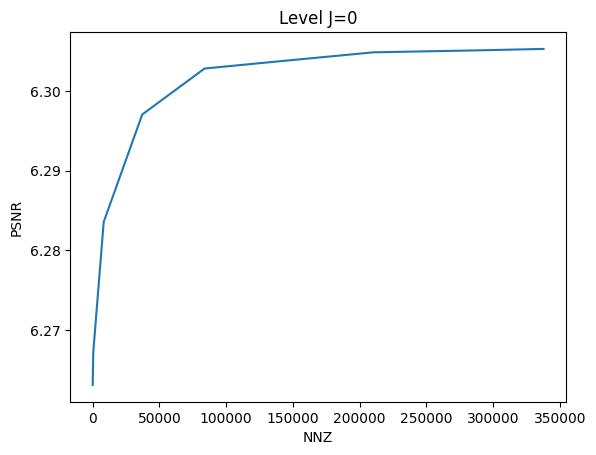

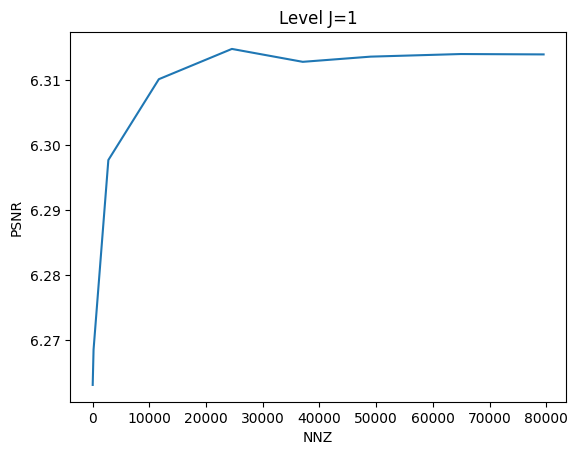

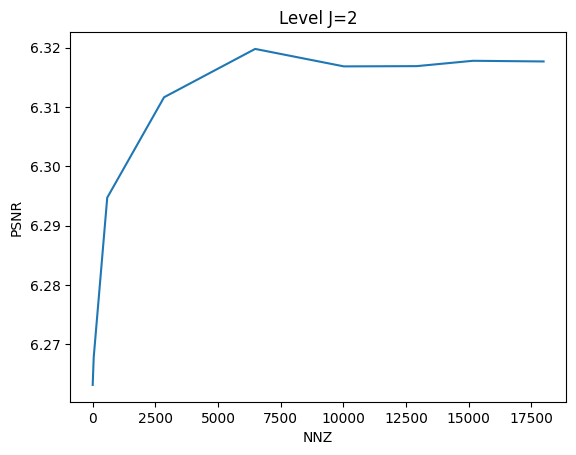

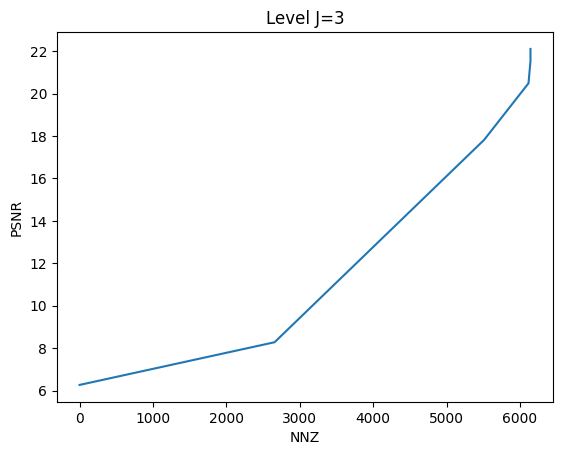

In [169]:
# Create initial PSNR and NNZ arrays
q = 9
PSNR = np.zeros((q+1,J+1))
NNZ = np.zeros((q+1,J+1))
[rows,cols] = np.shape(image)

# Calculate quantized pyramids
for n in range(q+1):
    Q = quantize_pyramid(L, 2**n, 0)
    R = reconstruct_laplacian(Q)

    # Calculate PSNR and NNZ for given levels
    for i in range(J+1):
        R_U = cv2.resize(R[i], (cols,rows))
        MSE = np.mean((image - R_U)**2) # Mean squared error
        PSNR[n,i] = 10*np.log10((255**2)/MSE) # Peak signal to noise ratio, for image in range [0,255]
        NNZ[n,i] = np.sum(Q[i] != 0)

# Plot PSNR vs NNZ
for i in range(J+1):
    plt.figure()
    plt.plot(NNZ[:,i], PSNR[:,i])
    plt.xlabel('NNZ')
    plt.ylabel('PSNR')
    plt.title(f'Level J={i}')

As the pyramid level increases, the image size gets smaller, since level 0 is the original image. At a certain point, specifically J=3, the PSNR for the given pyramid level increases at an exponential rate. This is somewhat expected, since as the pyramid level increases, we loose more and more of the data from the original image, so the potential error also increases.

Problem 1e:

For J=3, the curve shape of the PSNR vs NNZ plot has flipped. Instead of the PSNR reaching an equilibrium with the number of non-zero elements, it starts increasing exponentially. It appears that at around 6000 number of non-zeros the PSNR starts increasing faster than the NNZ.

Problem 2a: